In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import matplotlib.pyplot as plt

### data selection

In [7]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, encoding='gbk', index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation', '乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']
    data_df = data_df[columns]
    return data_df

In [8]:
interval = 3
forecast = 72
df_train = read_data_cn('data/time_series_375_prerpocess.xlsx', interval, forecast)
df_test = read_data_cn('data/time_series_test_110_preprocess.xlsx', interval, forecast)

# interpolate
df_train = df_train.interpolate(method='linear').ffill().bfill() 
df_test = df_test.interpolate(method='linear').ffill().bfill() 

In [5]:
df_train

,PATIENT_ID,period,decease,decompensation,乳酸脱氢酶,超敏C反应蛋白,淋巴细胞(%)
0,1.0,0.0,0.0,0.0,306.0,43.10,22.600000
1,1.0,1.0,0.0,0.0,278.0,23.35,24.250000
2,1.0,2.0,0.0,0.0,250.0,3.60,25.900000
3,1.0,3.0,0.0,0.0,200.0,3.10,10.500000
4,1.0,5.0,0.0,0.0,206.0,2.60,25.900000
...,...,...,...,...,...,...,...
1162,374.0,1.0,1.0,1.0,1867.0,61.70,2.300000
1163,375.0,0.0,1.0,0.0,915.0,58.50,9.900000
1164,375.0,1.0,1.0,0.0,1083.5,128.00,8.833333
1165,375.0,2.0,1.0,0.0,1252.0,197.50,7.766667


### create batch data by same length

In [11]:
def creat_batch_data(raw_data,outfile):
    
    index=raw_data.groupby(['PATIENT_ID'])['decease'].count()
    index=index.sort_values().reset_index()# sort
    index.columns = ['PATIENT_ID', 'time_length']
    index.head()
    time_length_count = index.groupby(['time_length'])['PATIENT_ID'].count().reset_index()
    time_length_count.columns=['time_length','count']
    time_length_count.head()
    
    batches=[]
    labels=[]
    intervals=[]
    for length in time_length_count['time_length']:
        PID_series=index[index['time_length']==length]['PATIENT_ID'].tolist()
        batch=[]
        label=[]
        interval=[]
        n=0
        for j in PID_series:
            temp = raw_data[raw_data['PATIENT_ID']==j]
            if temp['decease'].sum()==0:
                label.append([1,0]) # survival[1,0] die[0,1]
            else:
                label.append([0,1])
            features=temp.iloc[:,4:7].values.tolist() # 3 features
            batch.append(features)
            time=temp.iloc[:,1].values.tolist() # time interval
            interval.append(time)
            n+=1
            if n%256==0: # max 256 for a batch
                batches.append(batch)
                labels.append(label)
                batch=[]
                label=[]
        batches.append(batch)
        labels.append(label)
        intervals.append(interval)
    pickle.dump(batches, open('BatchData/' +outfile+ 'Data.seqs', 'wb'), -1) 
    pickle.dump(labels, open('BatchData/' +outfile+ 'Label.seqs', 'wb'), -1) 
    pickle.dump(intervals, open('BatchData/' +outfile+ 'Interval.seqs', 'wb'), -1) 

In [12]:
creat_batch_data(df_train,'Train')
creat_batch_data(df_test,'Test')

In [13]:
path_string = 'BatchData/TestData.seqs'
with open(path_string,'rb') as f:
    a = pickle.load(f)

In [14]:
a[0]

[[[195.0, 0.9, 35.5]],
 [[248.0, 1.4, 19.6]],
 [[178.0, 0.9, 35.8]],
 [[166.0, 1.6, 39.2]],
 [[342.0, 2.9, 11.0]],
 [[181.0, 16.6, 23.9]],
 [[178.0, 1.0, 48.1]],
 [[186.0, 1.6, 23.2]]]

In [ ]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, encoding='gbk', index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation', '乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']
    data_df = data_df[columns]
    return data_df

### dataset statistics

In [212]:
data_df = pd.read_excel('data/time_series_375_prerpocess.xlsx', encoding='gbk', index_col=[0])

In [26]:
# sample length count
count=data_df.groupby(['PATIENT_ID'])['RE_DATE'].count().reset_index()
sum_count=count.groupby(['RE_DATE']).count().reset_index()
sample_length=sum_count['RE_DATE'].tolist()
sample_length_count=sum_count['PATIENT_ID'].tolist()

In [40]:
# average length
total=0.0
counts=0.0
for i in range(len(sample_length)):
    total=total+sample_length[i]*sample_length_count[i]
    counts=counts+sample_length_count[i]
print(total/counts,total)

16.282666666666668 6106.0


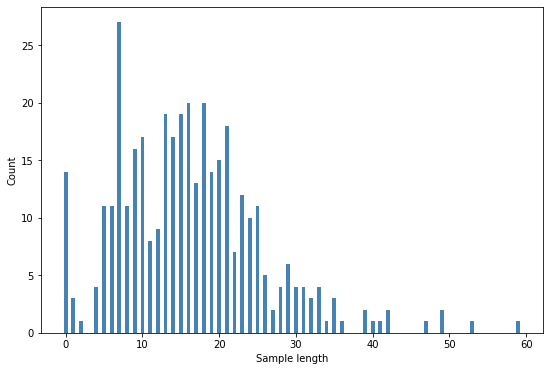

In [36]:
plt.figure(figsize=(9,6))
plt.bar(sample_length,sample_length_count, width=0.5 , color='steelblue')
plt.ylabel('Count')
plt.xlabel('Sample length')
plt.savefig('sample_length.jpg', dpi=300)
plt.show()

In [204]:
# missing rate
def missing_rate(data_df):
    missing_count=0.0
    for index, row in data_df.iterrows():
        for i in range(2,76):
            if(np.isnan(row[i])):
                missing_count=missing_count+1
    missing_rate=   missing_count / (data_df.shape[0]*74)
    return missing_rate

# group by interval 
def read_data_with_interval(interval,data_df,o_columns):
    # group by interval
    a=data_df
    a['total_period'] = a['出院时间'] - a['入院时间']
    a['total_period'] = a['total_period'].apply(lambda x: x.days//interval)
    a['period'] = a['出院时间'] - a['RE_DATE']
    a['period'] = a['period'].apply(lambda x: x.days//interval)
    a['period'] = a['total_period'] - a['period']
    a = a.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make it cleaner
    a = a.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    columns = ['PATIENT_ID', 'period']
    columns.extend(o_columns)
    a = a[columns]
    return a

In [213]:
o_columns=data_df.columns.values.tolist()[6:]
mrs=[]
for i in range(1,8):
    df=read_data_with_interval(i,data_df,o_columns)
    mr=missing_rate(df)
    mrs.append(mr)

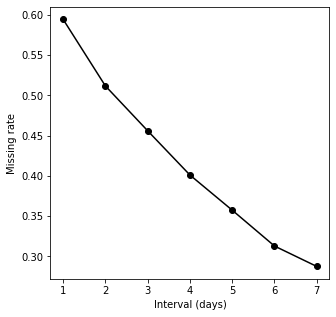

In [219]:
x=[1,2,3,4,5,6,7]
plt.figure(figsize=(5,5))
plt.plot(x,mrs,c='black',marker='o')
plt.xlabel('Interval (days)')
plt.ylabel('Missing rate')
#plt.gca().set_ylim(0,1)
plt.savefig('missing_rate.jpg', dpi=300)